In [61]:
from dotenv import load_dotenv
load_dotenv()

from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.vectorstores import Chroma

# Embedding function
embedding_function = OpenAIEmbeddings()

# Sample NASA-related documents
docs = [
    Document(
        page_content="NASA was established in 1958, succeeding the National Advisory Committee for Aeronautics (NACA). It is responsible for the civilian space program, as well as aeronautics and aerospace research in the United States.",
        metadata={"source": "nasa_history.txt"}
    ),
    Document(
        page_content="The Artemis program is NASA's latest effort to return humans to the Moon. Artemis I was an uncrewed test flight, while Artemis II will carry astronauts around the Moon. Artemis III aims to land humans on the lunar surface by the late 2020s.",
        metadata={"source": "artemis_program.txt"}
    ),
    Document(
        page_content="The International Space Station (ISS) is a collaborative effort between NASA, Roscosmos, ESA, JAXA, and CSA. It serves as a microgravity laboratory for research in biology, physics, astronomy, and more. It orbits Earth approximately every 90 minutes.",
        metadata={"source": "iss_overview.txt"}
    ),
    Document(
        page_content="NASA's James Webb Space Telescope (JWST) was launched in December 2021. It is the most powerful space telescope ever built, capable of observing galaxies formed shortly after the Big Bang. It operates primarily in the infrared spectrum.",
        metadata={"source": "jwst.txt"}
    ),
    Document(
        page_content="NASA's Mars missions include rovers like Curiosity and Perseverance. The Perseverance rover landed in Jezero Crater in 2021 and is collecting samples to be returned to Earth in a future mission. It also deployed the Ingenuity helicopter.",
        metadata={"source": "mars_missions.txt"}
    ),
    Document(
        page_content="NASA offers a wide range of internships, fellowships, and career opportunities for students and professionals. These programs span across disciplines including engineering, astrophysics, earth science, computer science, and public outreach.",
        metadata={"source": "nasa_careers.txt"}
    )
]

# Create vectorstore from documents
db = Chroma.from_documents(docs, embedding_function)
retriever = db.as_retriever(search_kwargs={"k": 3})

# Set up LLM
llm = ChatOpenAI(model="gpt-4o")

# Prompt template for RAG
template = """Answer the question based on the following context and the Chathistory. Especially take the latest question into consideration:

Chathistory: {history}

Context: {context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# Create RAG chain
rag_chain = prompt | llm


In [62]:
from typing import TypedDict, List
from langchain_core.messages import BaseMessage , HumanMessage, SystemMessage
from langgraph.graph import add_messages

class AgentState(TypedDict):

    messages : List[BaseMessage]
    documents: List[Document]
    on_topic: str
    rephrased_question: str
    proceed_to_generate: bool
    rephrase_count: int
    question: HumanMessage


def question_rewriter(state: AgentState):
    print(f"Entering question_rewriter with following state: {state}")

    # Reset state variables except for 'question' and 'messages'
    state["documents"] = []
    state["on_topic"] = ""
    state["rephrased_question"] = ""
    state["proceed_to_generate"] = False
    state["rephrase_count"] = 0

    if "messages" not in state or state["messages"] is None:
        state["messages"] = []

    if state["question"] not in state["messages"]:
        state["messages"].append(state["question"])

    if len(state["messages"]) > 1:
        conversation = state["messages"][:-1]
        current_question = state["question"].content
        messages = [
            SystemMessage(
                content="You are a helpful assistant that rephrases the user's question to be a standalone question optimized for retrieval."
            )
        ]
        messages.extend(conversation)
        messages.append(HumanMessage(content=current_question))
        rephrase_prompt = ChatPromptTemplate.from_messages(messages)
        llm = ChatOpenAI(model="gpt-4o-mini")
        prompt = rephrase_prompt.format()
        response = llm.invoke(prompt)
        better_question = response.content.strip()
        print(f"question_rewriter: Rephrased question: {better_question}")
        state["rephrased_question"] = better_question
    else:
        state["rephrased_question"] = state["question"].content
    return state


In [63]:
from langchain_core.prompts import ChatPromptTemplate
llm = ChatOpenAI()

from pydantic import BaseModel , Field

class GradeQuestion(BaseModel):
    """
    "Boolean value to check wether the question is from Anytime fitness gym or not
    """
    score : str = Field(description = "Question is about gym? if yes --> 'yes' else not --? 'no'")
    
def refine_query(state_obj: AgentState):
    print(f"Entering refine_query with current state: {state_obj}")

    # Reset non-essential keys
    state_obj["retrieved_docs"] = []
    state_obj["topic_match"] = ""
    state_obj["refined_query"] = ""
    state_obj["ready_to_generate"] = False
    state_obj["rewrite_attempts"] = 0

    if "messages" not in state_obj or state_obj["messages"] is None:
        state_obj["messages"] = []

    if state_obj["question"] not in state_obj["messages"]:
        state_obj["messages"].append(state_obj["question"])

    if len(state_obj["messages"]) > 1:
        previous_msgs = state_obj["messages"][:-1]
        latest_q = state_obj["question"].content

        chat_sequence = [
            SystemMessage(
                content="You are a helpful assistant that rephrases the user's question to be a standalone question optimized for retrieval."
            )
        ]
        chat_sequence.extend(previous_msgs)
        chat_sequence.append(HumanMessage(content=latest_q))

        reform_prompt = ChatPromptTemplate.from_messages(chat_sequence)
        chat_model = ChatOpenAI(model="gpt-4o-mini")
        prompt_text = reform_prompt.format()
        llm_response = chat_model.invoke(prompt_text)
        refined_text = llm_response.content.strip()

        print(f"refine_query: Refined question: {refined_text}")
        state_obj["refined_query"] = refined_text
    else:
        state_obj["refined_query"] = state_obj["question"].content

    return state_obj



In [64]:
def question_classifier(state: AgentState):
    print("Entering question_classifier")
    system_message = SystemMessage(
        content=""" You are a classifier that determines whether a user's question is about one of the following topics 
    
    1. Gym History & Founder
    2. Operating Hours
    3. Membership Plans 
    4. Fitness Classes
    5. Personal Trainers
    6. Facilities & Equipment
    7. Anything else about Peak Performance Gym
    
    If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.

    """
    )

    human_message = HumanMessage(
        content=f"User question: {state['rephrased_question']}"
    )
    grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    llm = ChatOpenAI(model="gpt-4o")
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({})
    state["on_topic"] = result.score.strip()
    print(f"question_classifier: on_topic = {state['on_topic']}")
    return state

In [65]:
def on_topic_router(state: AgentState):
    print("Entering on_topic_router")
    on_topic = state.get("on_topic", "").strip().lower()
    if on_topic == "yes":
        print("Routing to retrieve")
        return "retrieve"
    else:
        print("Routing to off_topic_response")
        return "off_topic_response"

In [66]:
def retrieve(state: AgentState):
    print("Entering retrieve")
    documents = retriever.invoke(state["rephrased_question"])
    print(f"retrieve: Retrieved {len(documents)} documents")
    state["documents"] = documents
    return state

In [67]:
from langchain_core.messages import AIMessage
class GradeDocument(BaseModel):
    score: str = Field(
        description="Document is relevant to the question? If yes -> 'Yes' if not -> 'No'"
    )

def retrieval_grader(state: AgentState):
    print("Entering retrieval_grader")
    system_message = SystemMessage(
        content="""You are a grader assessing the relevance of a retrieved document to a user question.
Only answer with 'Yes' or 'No'.

If the document contains information relevant to the user's question, respond with 'Yes'.
Otherwise, respond with 'No'."""
    )

    llm = ChatOpenAI(model="gpt-4o")
    structured_llm = llm.with_structured_output(GradeDocument)

    relevant_docs = []
    for doc in state["documents"]:
        human_message = HumanMessage(
            content=f"User question: {state['rephrased_question']}\n\nRetrieved document:\n{doc.page_content}"
        )
        grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
        grader_llm = grade_prompt | structured_llm
        result = grader_llm.invoke({})
        print(
            f"Grading document: {doc.page_content[:30]}... Result: {result.score.strip()}"
        )
        if result.score.strip().lower() == "yes":
            relevant_docs.append(doc)
    state["documents"] = relevant_docs
    state["proceed_to_generate"] = len(relevant_docs) > 0
    print(f"retrieval_grader: proceed_to_generate = {state['proceed_to_generate']}")
    return state

def proceed_router(state: AgentState):
    print("Entering proceed_router")
    rephrase_count = state.get("rephrase_count", 0)
    if state.get("proceed_to_generate", False):
        print("Routing to generate_answer")
        return "generate_answer"
    elif rephrase_count >= 2:
        print("Maximum rephrase attempts reached. Cannot find relevant documents.")
        return "cannot_answer"
    else:
        print("Routing to refine_question")
        return "refine_question"
    
def refine_question(state: AgentState):
    print("Entering refine_question")
    rephrase_count = state.get("rephrase_count", 0)
    if rephrase_count >= 2:
        print("Maximum rephrase attempts reached")
        return state
    question_to_refine = state["rephrased_question"]
    system_message = SystemMessage(
        content="""You are a helpful assistant that slightly refines the user's question to improve retrieval results.
Provide a slightly adjusted version of the question."""
    )
    human_message = HumanMessage(
        content=f"Original question: {question_to_refine}\n\nProvide a slightly refined question."
    )
    refine_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    llm = ChatOpenAI(model="gpt-4o")
    prompt = refine_prompt.format()
    response = llm.invoke(prompt)
    refined_question = response.content.strip()
    print(f"refine_question: Refined question: {refined_question}")
    state["rephrased_question"] = refined_question
    state["rephrase_count"] = rephrase_count + 1
    return state

def generate_answer(state: AgentState):
    print("Entering generate_answer")
    if "messages" not in state or state["messages"] is None:
        raise ValueError("State must include 'messages' before generating an answer.")

    history = state["messages"]
    documents = state["documents"]
    rephrased_question = state["rephrased_question"]

    response = rag_chain.invoke(
        {"history": history, "context": documents, "question": rephrased_question}
    )

    generation = response.content.strip()

    state["messages"].append(AIMessage(content=generation))
    print(f"generate_answer: Generated response: {generation}")
    return state

def cannot_answer(state: AgentState):
    print("Entering cannot_answer")
    if "messages" not in state or state["messages"] is None:
        state["messages"] = []
    state["messages"].append(
        AIMessage(
            content="I'm sorry, but I cannot find the information you're looking for."
        )
    )
    return state


def off_topic_response(state: AgentState):
    print("Entering off_topic_response")
    if "messages" not in state or state["messages"] is None:
        state["messages"] = []
    state["messages"].append(AIMessage(content="I'm sorry! I cannot answer this question!"))
    return state

In [68]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

In [82]:
from langgraph.graph import StateGraph , END
# Workflow
workflow = StateGraph(AgentState)
workflow.add_node("refine_query", refine_query)                
workflow.add_node("categorize_question", question_classifier)  
workflow.add_node("respond_off_topic", off_topic_response)     
workflow.add_node("fetch_context", retrieve)                   
workflow.add_node("grade_retrieval", retrieval_grader)         
workflow.add_node("generate_response", generate_answer)       
workflow.add_node("rework_query", refine_question)             
workflow.add_node("no_answer", cannot_answer)   

workflow.add_edge("refine_query", "categorize_question")
workflow.add_conditional_edges(
    "categorize_question",
    on_topic_router,
    {
        "fetch_context": "fetch_context",
        "respond_off_topic": "respond_off_topic",
    },
)
workflow.add_edge("fetch_context", "grade_retrieval")
workflow.add_conditional_edges(
    "grade_retrieval",
    proceed_router,
    {
        "generate_response": "generate_response",
        "refine_query": "refine_query",
        "no_answer": "no_answer",
    },
)
workflow.add_edge("refine_query", "fetch_context")
workflow.add_edge("generate_response", END)
workflow.add_edge("no_answer", END)
workflow.add_edge("respond_off_topic", END)
workflow.set_entry_point("refine_query")
graph = workflow.compile(checkpointer=checkpointer)


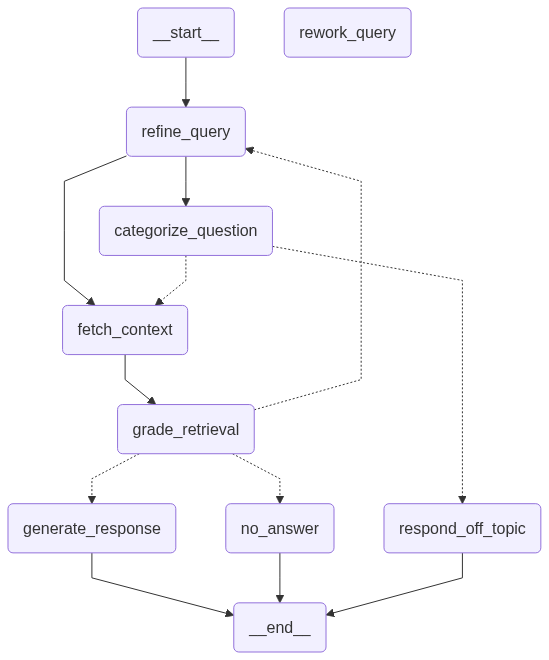

In [83]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
input_data = {"question": HumanMessage(content="What does the company Apple do?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})

Entering question_rewriter with following state: {'question': HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = No
Entering on_topic_router
Routing to off_topic_response
Entering off_topic_response


{'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm sorry! I cannot answer this question!", additional_kwargs={}, response_metadata={})],
 'documents': [],
 'on_topic': 'No',
 'rephrased_question': 'What does the company Apple do?',
 'proceed_to_generate': False,
 'rephrase_count': 0,
 'question': HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={})}

In [ ]:
input_data = {
    "question": HumanMessage(
        content="What is the cancelation policy for Peak Performance Gym memberships?"
    )
}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 2}})

Entering question_rewriter with following state: {'question': HumanMessage(content='What is the cancelation policy for Peak Performance Gym memberships?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 3 documents
Entering retrieval_grader
Grading document: Peak Performance Gym is open M... Result: No
Grading document: Peak Performance Gym is open M... Result: No
Grading document: Peak Performance Gym is open M... Result: No
retrieval_grader: proceed_to_generate = False
Entering proceed_router
Routing to refine_question
Entering refine_question
refine_question: Refined question: What is the cancellation policy for memberships at Peak Performance Gym?
Entering retrieve
retrieve: Retrieved 3 documents
Entering retrieval_grader
Grading document: Group fitness classes at Peak ... Result: No
Grading document: Peak Performance Gym is open M... Resu

{'messages': [HumanMessage(content='What is the cancelation policy for Peak Performance Gym memberships?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm sorry, but I cannot find the information you're looking for.", additional_kwargs={}, response_metadata={})],
 'documents': [],
 'on_topic': 'Yes',
 'rephrased_question': 'Revised question: Can you provide details about the cancellation policy for memberships at Peak Performance Gym?',
 'proceed_to_generate': False,
 'rephrase_count': 2,
 'question': HumanMessage(content='What is the cancelation policy for Peak Performance Gym memberships?', additional_kwargs={}, response_metadata={})}

In [ ]:
input_data = {
    "question": HumanMessage(content="Who founded Peak Performance Gym?")
}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 3}})

Entering question_rewriter with following state: {'question': HumanMessage(content='Who founded Peak Performance Gym?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 3 documents
Entering retrieval_grader
Grading document: Peak Performance Gym was found... Result: Yes
Grading document: Peak Performance Gym was found... Result: Yes
Grading document: Peak Performance Gym was found... Result: Yes
retrieval_grader: proceed_to_generate = True
Entering proceed_router
Routing to generate_answer
Entering generate_answer
generate_answer: Generated response: Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen.


{'messages': [HumanMessage(content='Who founded Peak Performance Gym?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen.', additional_kwargs={}, response_metadata={})],
 'documents': [Document(metadata={'source': 'about.txt'}, page_content='Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.'),
  Document(metadata={'source': 'about.txt'}, page_content='Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-t

In [44]:
input_data = {"question": HumanMessage(content="When did he start it?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 3}})

Entering question_rewriter with following state: {'messages': [HumanMessage(content='Who founded Peak Performance Gym?', additional_kwargs={}, response_metadata={}), AIMessage(content='Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen.', additional_kwargs={}, response_metadata={})], 'documents': [Document(metadata={'source': 'about.txt'}, page_content='Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.'), Document(metadata={'source': 'about.txt'}, page_content='Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym span

{'messages': [HumanMessage(content='Who founded Peak Performance Gym?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='When did he start it?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Peak Performance Gym was established in 2015.', additional_kwargs={}, response_metadata={})],
 'documents': [Document(metadata={'source': 'about.txt'}, page_content='Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.'),
  Document(metadata={'source': 'about.txt'}, page_content='Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With